In [2]:
import math
import os
import warnings
warnings.filterwarnings("ignore")
import mldatasets
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.utils import get_file
import matplotlib.pyplot as plt
import seaborn as sns

#PART 1 only
from sklearn import metrics
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, BasicIterativeMethod
from art.attacks.evasion import CarliniLInfMethod
from art.attacks.evasion import AdversarialPatchNumpy
from art.defences.preprocessor import SpatialSmoothing
from art.defences.trainer import AdversarialTrainer
from tqdm.notebook import tqdm

#PART 2 only
from art.estimators.classification import TensorFlowV2Classifier
from art.estimators.certification.randomized_smoothing import TensorFlowV2RandomizedSmoothing
from art.utils import compute_accuracy

In [2]:
print(tf.__version__)

2.2.1


In [3]:
tf.compat.v1.disable_eager_execution()
print('Eager execution enabled: ', tf.executing_eagerly()) 

Eager execution enabled:  False


In [4]:
X_train, X_test, y_train, y_test =\
                                    mldatasets.load("maskedface-net_thumbs_sampled", prepare=True)
X_train, X_test = X_train / 255.0, X_test / 255.0
min_ = X_train.min()
max_ = X_train.max()

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/maskedface-net_thumbs_sampled.zip downloaded to /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter13/data/maskedface-net_thumbs_sampled.zip
/Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter13/data/maskedface-net_thumbs_sampled.zip uncompressed to /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter13/data/maskedface-net_thumbs_sampled
21000 dataset files found in /Users/smasis/Documents/OTHER/InterpretableMLBook/programming/Chapter13/data/maskedface-net_thumbs_sampled folder


In [5]:
print('X_train dim:\t%s' % (X_train.shape,))
print('X_test dim:\t%s' % (X_test.shape,))
print('y_train dim:\t%s' % (y_train.shape,))
print('y_test dim:\t%s' % (y_test.shape,))
print('X_train min:\t%s' % (min_))
print('X_train max:\t%s' % (max_))
print('y_train labels:\t%s' % (np.unique(y_train)))

X_train dim:	(16800, 128, 128, 3)
X_test dim:	(4200, 128, 128, 3)
y_train dim:	(16800, 1)
y_test dim:	(4200, 1)
X_train min:	0.0
X_train max:	1.0
y_train labels:	['Correct' 'Incorrect' 'None']


In [6]:
ohe = preprocessing.OneHotEncoder(sparse=False)
ohe.fit(y_train)
labels_l = ohe.categories_[0].tolist()
print(labels_l)

['Correct', 'Incorrect', 'None']


In [7]:
rand = 9
os.environ['PYTHONHASHSEED'] = str(rand)
tf.random.set_seed(rand)
np.random.seed(rand)

In [8]:
sampl_md_idxs = np.random.choice(X_test.shape[0], 200, replace=False)
X_test_mdsample = X_test[sampl_md_idxs]
y_test_mdsample = y_test[sampl_md_idxs]
sampl_sm_idxs = np.random.choice(X_test.shape[0], 20, replace=False)
X_test_smsample = X_test[sampl_sm_idxs]
y_test_smsample = y_test[sampl_sm_idxs]

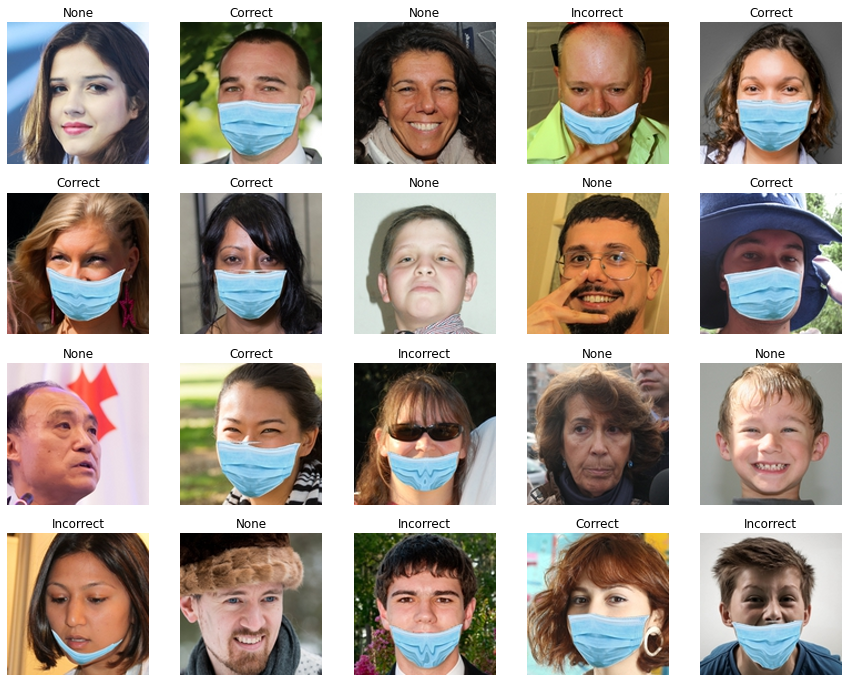

In [9]:
plt.subplots(figsize=(15,12))
for s in range(20):
    plt.subplot(4, 5, s+1)
    plt.title(y_test_smsample[s][0], fontsize=12)
    plt.imshow(X_test_smsample[s], interpolation='spline16')
    plt.axis('off')
plt.show()

In [10]:
base_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', name='conv2d_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_1'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_2'),
    tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation='relu', name='conv2d_3'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name="maxpool2d_3"),
    tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', name='conv2d_4'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_4'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(768, activation='relu', name='dense_1'),
    tf.keras.layers.Dropout(0.35),
    tf.keras.layers.Dense(3, activation='softmax', name='dense_2')
], name='CNN_Base_MaskedFaceNet_Model')

base_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

base_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "CNN_Base_MaskedFaceNet_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
maxpool2d_3 (MaxPooling2D)   (None, 14, 14, 64)        0         
_______________________

In [617]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1,\
                                patience=3, restore_best_weights=True) 

base_model.fit(X_train, ohe.transform(y_train), validation_split=0.2,\
               batch_size=128, callbacks=[es], epochs=30, verbose=1)

_, accuracy_test = base_model.evaluate(X_test, ohe.transform(y_test))
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

tostring() is deprecated. Use tobytes() instead.


Train on 16800 samples, validate on 4200 samples
Epoch 1/30
16800/16800 [==============================] - 54s 3ms/sample - loss: 0.1584 - accuracy: 0.9399 - val_loss: 0.0276 - val_accuracy: 0.9948
Epoch 2/30
16800/16800 [==============================] - 55s 3ms/sample - loss: 0.0219 - accuracy: 0.9952 - val_loss: 0.0303 - val_accuracy: 0.9936
Epoch 3/30
16800/16800 [==============================] - 56s 3ms/sample - loss: 0.0236 - accuracy: 0.9940 - val_loss: 0.0221 - val_accuracy: 0.9957
Epoch 4/30
16800/16800 [==============================] - 55s 3ms/sample - loss: 0.0170 - accuracy: 0.9961 - val_loss: 0.0222 - val_accuracy: 0.9962
Epoch 5/30
16800/16800 [==============================] - 56s 3ms/sample - loss: 0.0134 - accuracy: 0.9974 - val_loss: 0.0235 - val_accuracy: 0.9962
Epoch 6/30
16800/16800 [==============================] - 56s 3ms/sample - loss: 0.0125 - accuracy: 0.9975 - val_loss: 0.0201 - val_accuracy: 0.9955
Epoch 7/30
16800/16800 [==============================] -

In [11]:
model_path = get_file('CNN_Base_MaskedFace_Net.hdf5',\
                      'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/blob/master/models/CNN_Base_MaskedFace_Net.hdf5?raw=true')
base_model = tf.keras.models.load_model(model_path)
base_model.summary()

43737088/43734584 [==============================] - 8s 0us/step
Model: "CNN_Base_MaskedFaceNet_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
maxpool2d_3 (MaxPooling2D)   (None, 14, 14, 64)        0         
_______________________________________

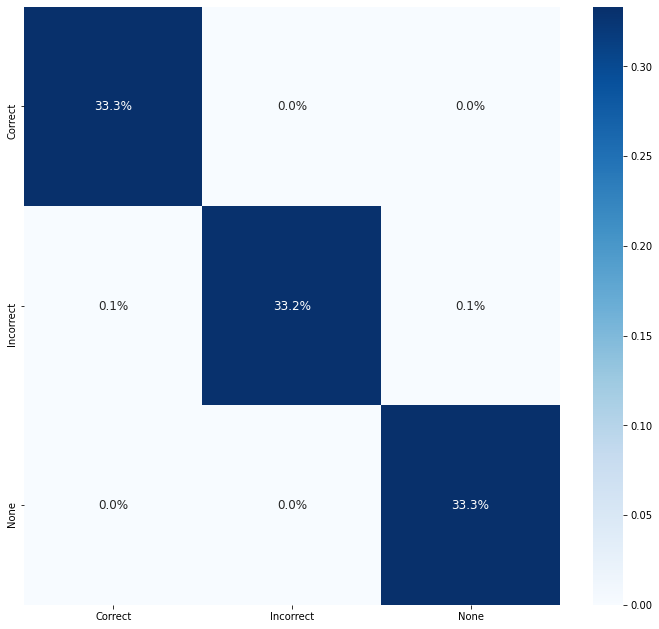

              precision    recall  f1-score   support

     Correct      0.998     0.998     0.998      1400
   Incorrect      0.999     0.995     0.997      1400
        None      0.996     0.999     0.998      1400

    accuracy                          0.997      4200
   macro avg      0.997     0.997     0.997      4200
weighted avg      0.997     0.997     0.997      4200



In [12]:
y_test_pred, y_test_prob = mldatasets.evaluate_multiclass_mdl(base_model, X_test, y_test, labels_l, ohe,\
                                                    plot_conf_matrix=True, predopts={"verbose":1})

In [13]:
base_classifier = KerasClassifier(model=base_model, clip_values=(min_, max_))
y_test_mdsample_prob = np.max(y_test_prob[sampl_md_idxs], axis=1)
y_test_smsample_prob = np.max(y_test_prob[sampl_sm_idxs], axis=1)

In [15]:
attack_fgsm = FastGradientMethod(base_classifier, eps=0.1)

In [16]:
X_test_fgsm = attack_fgsm.generate(X_test_mdsample)

              precision    recall  f1-score   support

     Correct      0.056     0.014     0.023        70
   Incorrect      0.220     0.370     0.276        54
        None      0.736     0.882     0.802        76

    accuracy                          0.440       200
   macro avg      0.337     0.422     0.367       200
weighted avg      0.359     0.440     0.387       200



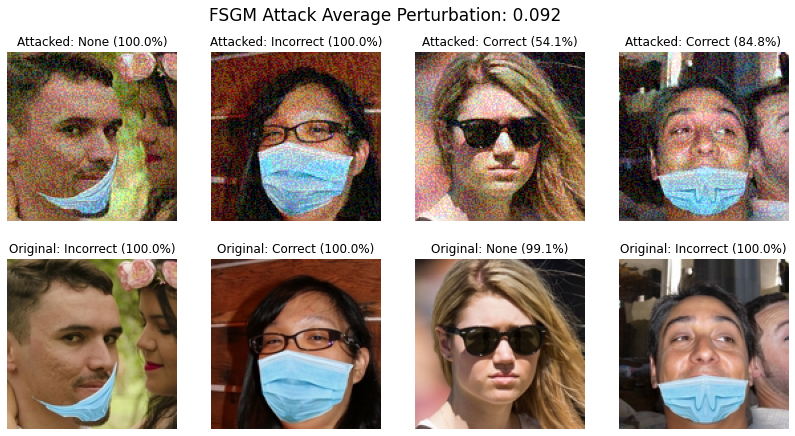

In [20]:
y_test_fgsm_pred, y_test_fgsm_prob =\
    mldatasets.evaluate_multiclass_mdl(base_classifier.model, X_test_fgsm, y_test_mdsample,\
                                       labels_l, ohe, plot_conf_matrix=False, plot_roc=False)
y_test_fgsm_prob = np.max(y_test_fgsm_prob, axis=1)

mldatasets.compare_image_predictions(X_test_fgsm, X_test_mdsample, y_test_fgsm_pred,\
                                     y_test_mdsample.flatten(), y_test_fgsm_prob,\
                                     y_test_mdsample_prob, title_mod_prefix="Attacked: ",\
                                     title_difference_prefix="FSGM Attack Average Perturbation: ",\
                                     num_samples=4)

In [21]:
attack_cw = CarliniLInfMethod(base_classifier, eps=0.3, batch_size=40)
X_test_cw = attack_cw.generate(X_test_mdsample)

C&W L_inf: 100%|██████████| 5/5 [01:03<00:00, 12.62s/it]


              precision    recall  f1-score   support

     Correct      0.932     0.971     0.951        70
   Incorrect      0.839     0.963     0.897        54
        None      0.985     0.842     0.908        76

    accuracy                          0.920       200
   macro avg      0.918     0.925     0.918       200
weighted avg      0.927     0.920     0.920       200



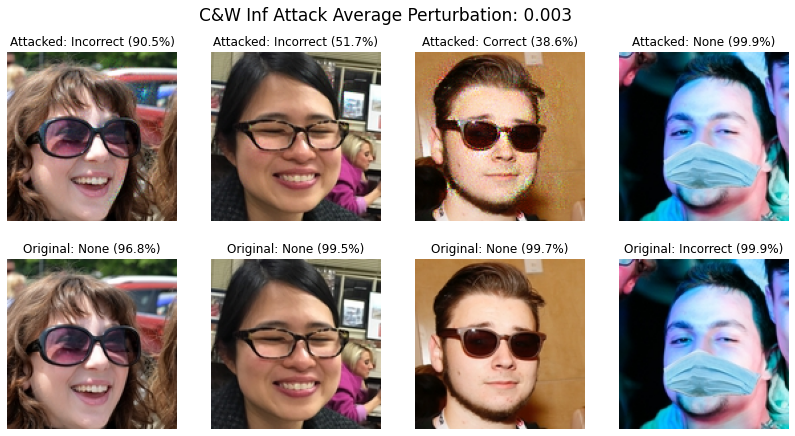

In [38]:
y_test_cw_pred, y_test_cw_prob =\
    mldatasets.evaluate_multiclass_mdl(base_classifier.model, X_test_cw, y_test_mdsample,\
                                       labels_l, ohe, plot_conf_matrix=False, plot_roc=False)
y_test_cw_prob = np.max(y_test_cw_prob, axis=1)

mldatasets.compare_image_predictions(X_test_cw, X_test_mdsample, y_test_cw_pred,\
                                     y_test_mdsample.flatten(), y_test_cw_prob,\
                                     y_test_mdsample_prob, title_mod_prefix="Attacked: ",\
                                     title_difference_prefix="C&W Inf Attack Average Perturbation: ",\
                                     num_samples=4)

In [220]:
attack_ap = AdversarialPatchNumpy(base_classifier, scale_min=0.4, scale_max=0.7,\
                                  learning_rate=5., max_iter=500, batch_size=40,\
                                  target=0)


In [238]:
placement_mask = np.zeros((128,128))
placement_mask[80:93,45:83] = 1
placement_mask = np.expand_dims(placement_mask, axis=0).astype(bool)

patch, patch_mask = attack_ap.generate(x=X_test_smsample,\
                                       y=ohe.transform(y_test_smsample),\
                                       mask=placement_mask)

Adversarial Patch Numpy: 100%|██████████| 500/500 [03:39<00:00,  2.28it/s]


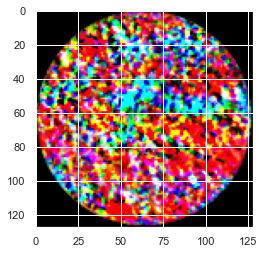

In [239]:
plt.imshow(patch * patch_mask)
plt.show()

In [240]:
X_test_ap = attack_ap.apply_patch(X_test_smsample, scale=0.55, mask=placement_mask)

              precision    recall  f1-score   support

     Correct      0.667     0.571     0.615         7
   Incorrect      0.750     0.600     0.667         5
        None      0.600     0.750     0.667         8

    accuracy                          0.650        20
   macro avg      0.672     0.640     0.650        20
weighted avg      0.661     0.650     0.649        20



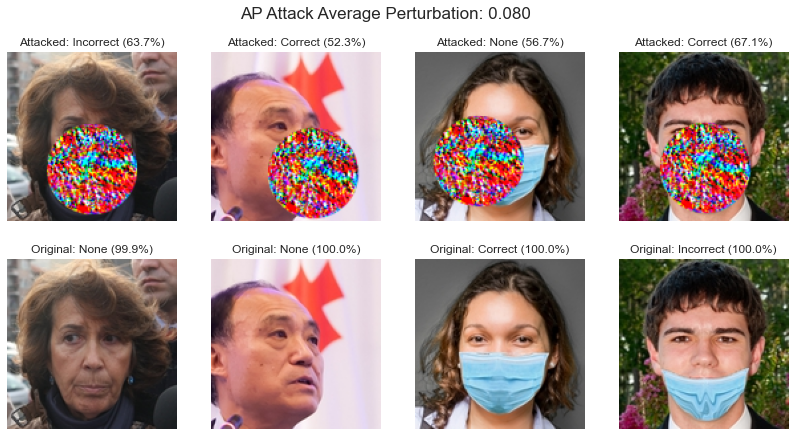

In [262]:
y_test_ap_pred, y_test_ap_prob =\
    mldatasets.evaluate_multiclass_mdl(base_classifier.model, X_test_ap, y_test_smsample,\
                                       labels_l, ohe, plot_conf_matrix=False, plot_roc=False)
y_test_ap_prob = np.max(y_test_ap_prob, axis=1)

mldatasets.compare_image_predictions(X_test_ap, X_test_smsample, y_test_ap_pred,\
                                     y_test_smsample.flatten(), y_test_ap_prob,\
                                     y_test_smsample_prob, title_mod_prefix="Attacked: ",\
                                     title_difference_prefix="AP Attack Average Perturbation: ",\
                                     num_samples=4)

In [62]:
not_masked_idxs = np.where(y_test_smsample != 'Correct')[0]
X_test_notmasked = X_test_smsample[not_masked_idxs]
y_test_notmasked = y_test_smsample[not_masked_idxs]
y_test_notmasked_prob = y_test_smsample_prob[not_masked_idxs]
y_test_masked = np.array(['Correct'] * X_test_notmasked.shape[0]).reshape(-1,1)

In [63]:
attack_pgd = ProjectedGradientDescent(base_classifier, eps=0.3, eps_step=0.01, max_iter=40,\
                                      targeted=True)
X_test_pgd = attack_pgd.generate(X_test_notmasked,\
                                 y=ohe.transform(y_test_masked))

PGD - Random Initializations: 100%|██████████| 1/1 [00:03<00:00,  3.42s/it]


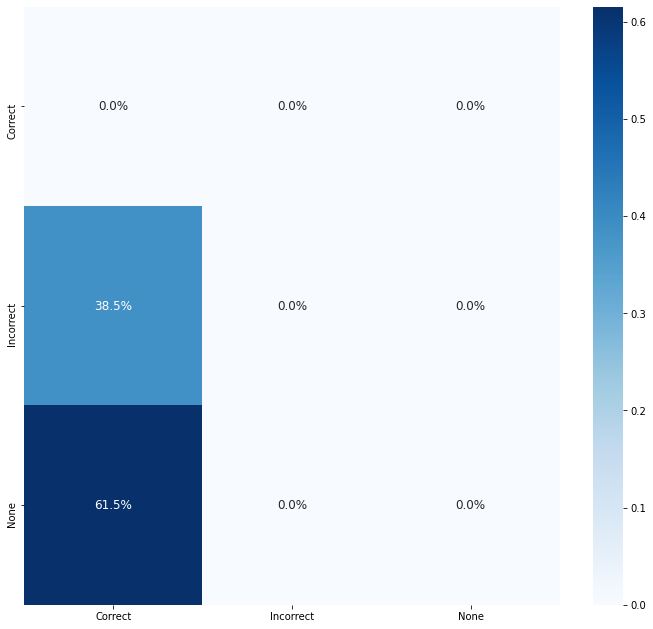

              precision    recall  f1-score   support

     Correct      0.000     0.000     0.000       0.0
   Incorrect      0.000     0.000     0.000       5.0
        None      0.000     0.000     0.000       8.0

    accuracy                          0.000      13.0
   macro avg      0.000     0.000     0.000      13.0
weighted avg      0.000     0.000     0.000      13.0



In [64]:
y_test_pgd_pred, y_test_pgd_prob =\
    mldatasets.evaluate_multiclass_mdl(base_classifier.model, X_test_pgd, y_test_notmasked,\
                                       labels_l, ohe, plot_conf_matrix=True, plot_roc=False)
y_test_pgd_prob = np.max(y_test_pgd_prob, axis=1)

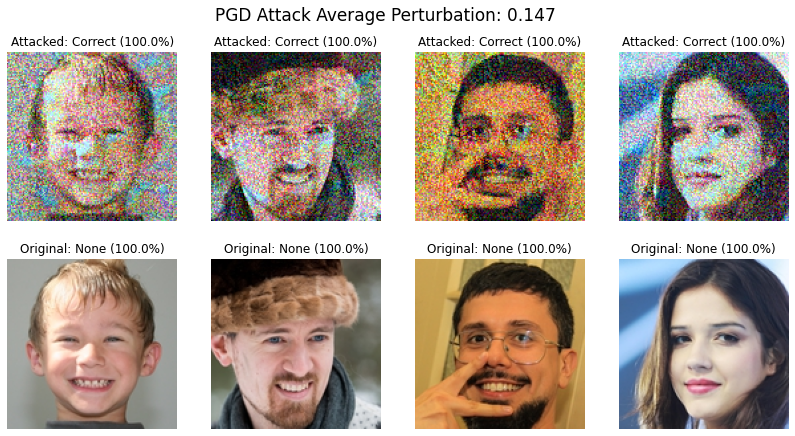

In [94]:
mldatasets.compare_image_predictions(X_test_pgd, X_test_notmasked, y_test_pgd_pred,\
                                     y_test_notmasked.flatten(), y_test_pgd_prob, y_test_smsample_prob,\
                                     title_mod_prefix="Attacked: ", num_samples=4,\
                                     title_difference_prefix="PGD Attack Average Perturbation: ")

In [69]:
defence_ss = SpatialSmoothing(window_size=11)
X_test_pgd_ss, _ = defence_ss(X_test_pgd)

In [73]:
y_test_pgd_ss_pred, y_test_pgd_ss_prob =\
    mldatasets.evaluate_multiclass_mdl(base_classifier.model, X_test_pgd_ss, y_test_notmasked,\
                                       labels_l, ohe, plot_conf_matrix=False, plot_roc=False)
y_test_pgd_ss_prob = np.max(y_test_pgd_ss_prob, axis=1)

              precision    recall  f1-score   support

     Correct      0.000     0.000     0.000         0
   Incorrect      1.000     0.600     0.750         5
        None      0.800     0.500     0.615         8

    accuracy                          0.538        13
   macro avg      0.600     0.367     0.455        13
weighted avg      0.877     0.538     0.667        13



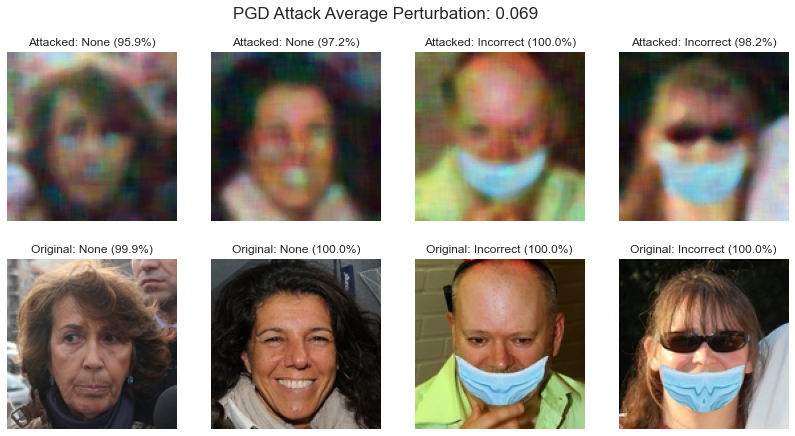

In [117]:
mldatasets.compare_image_predictions(X_test_pgd_ss, X_test_notmasked, y_test_pgd_ss_pred,\
                                     y_test_notmasked.flatten(), y_test_pgd_ss_prob, y_test_notmasked_prob,\
                                     title_mod_prefix="Attacked: ", num_samples=4,\
                                     title_difference_prefix="PGD Attack Average Perturbation: ",\
                                     use_misclass=False)

In [4]:
robust_model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=X_train.shape[1:]),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_1'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_1'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_2'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_2'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_3'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_3'),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', name='conv2d_4'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='maxpool2d_4'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3072, activation='relu', name='dense_1'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax', name='dense_2')
], name='CNN_Robust_MaskedFaceNet_Model')

robust_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

robust_model.summary()

Model: "CNN_Robust_MaskedFaceNet_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
maxpool2d_3 (MaxPooling2D)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 

In [218]:
robust_classifier = KerasClassifier(model=robust_model, clip_values=(min_, max_))
attacks = BasicIterativeMethod(robust_classifier, eps=0.3, eps_step=0.01, max_iter=20)
trainer = AdversarialTrainer(robust_classifier, attacks, ratio=0.5)
trainer.fit(X_train, ohe.transform(y_train), nb_epochs=30, batch_size=128)

Adversarial training epochs: 100%|██████████| 30/30 [8:23:54<00:00, 1007.83s/it]  

CPU times: user 1d 21h 40min 50s, sys: 3h 53min 11s, total: 2d 1h 34min 1s
Wall time: 8h 23min 54s


In [96]:
model_path = get_file('CNN_Robust_MaskedFace_Net.hdf5',\
                      'https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/blob/master/models/CNN_Robust_MaskedFace_Net.hdf5?raw=true')
robust_model = tf.keras.models.load_model(model_path)
robust_classifier = KerasClassifier(model=robust_model, clip_values=(min_, max_))

43024384/43019888 [==============================] - 9s 0us/step


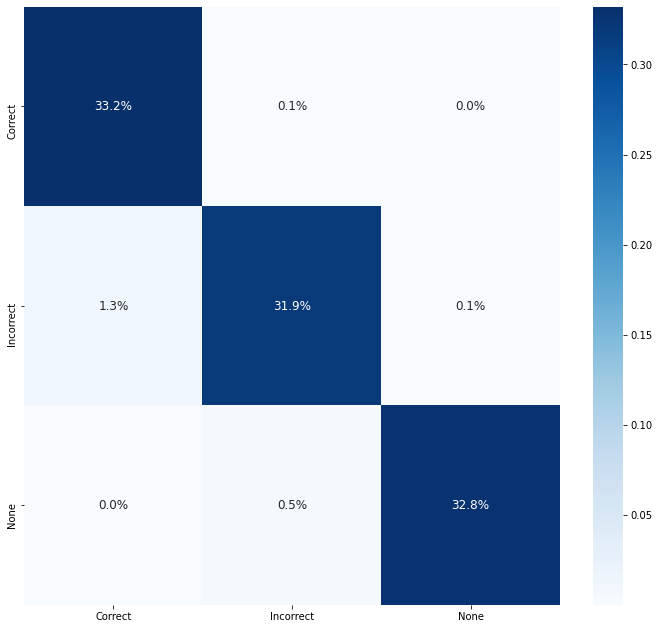

              precision    recall  f1-score   support

     Correct      0.962     0.996     0.979      1400
   Incorrect      0.980     0.957     0.969      1400
        None      0.994     0.983     0.989      1400

    accuracy                          0.979      4200
   macro avg      0.979     0.979     0.979      4200
weighted avg      0.979     0.979     0.979      4200



In [97]:
y_test_robust_pred, y_test_robust_prob =\
                mldatasets.evaluate_multiclass_mdl(robust_classifier.model, X_test, y_test,\
                                                   labels_l, ohe, plot_conf_matrix=True,\
                                                   predopts={"verbose":1})

In [100]:
attack_fgsm_robust = FastGradientMethod(robust_classifier, eps=0.1)
X_test_fgsm_robust = attack_fgsm_robust.generate(X_test_mdsample)

              precision    recall  f1-score   support

     Correct      0.921     1.000     0.959        70
   Incorrect      0.942     0.907     0.925        54
        None      1.000     0.947     0.973        76

    accuracy                          0.955       200
   macro avg      0.954     0.952     0.952       200
weighted avg      0.957     0.955     0.955       200



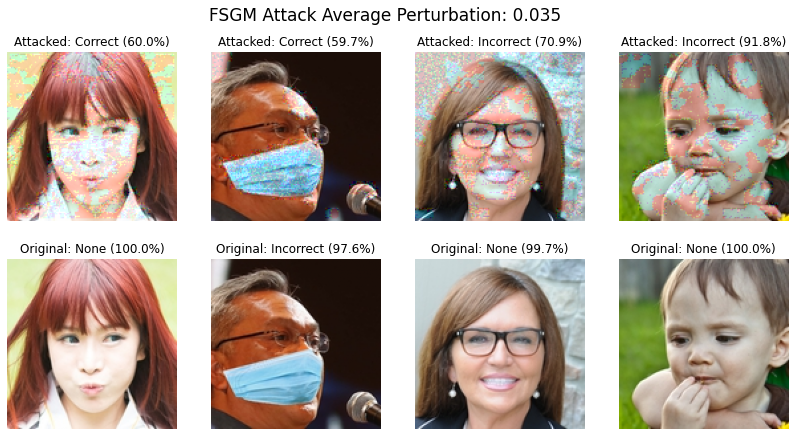

In [108]:
y_test_fgsm_robust_pred, y_test_fgsm_robust_prob =\
    mldatasets.evaluate_multiclass_mdl(robust_classifier.model, X_test_fgsm_robust, y_test_mdsample,\
                                       labels_l, ohe, plot_conf_matrix=False, plot_roc=False)
y_test_fgsm_robust_prob = np.max(y_test_fgsm_robust_prob, axis=1)

mldatasets.compare_image_predictions(X_test_fgsm_robust, X_test_mdsample, y_test_fgsm_robust_pred,\
                                     y_test_mdsample.flatten(), y_test_fgsm_robust_prob,\
                                     y_test_mdsample_prob, title_mod_prefix="Attacked: ",\
                                     title_difference_prefix="FSGM Attack Average Perturbation: ",\
                                     num_samples=4)

In [112]:
accuracy_base_0 = metrics.accuracy_score(y_test, y_test_pred)
accuracy_robust_0 = metrics.accuracy_score(y_test, y_test_robust_pred)

In [113]:
%%time
eps_range = np.concatenate((np.linspace(0.01, 0.09, 9),\
                            np.linspace(0.1, 0.9, 9)), axis=0).tolist()

accuracy_base = [accuracy_base_0]
accuracy_robust = [accuracy_robust_0]
for eps in tqdm(eps_range, desc='EPS'):
    attack_fgsm.set_params(**{'eps': eps})
    X_test_fgsm_base_i = attack_fgsm.generate(X_test_mdsample)
    _, accuracy_base_i = base_classifier.model.evaluate(X_test_fgsm_base_i,\
                                            ohe.transform(y_test_mdsample))
    
    attack_fgsm_robust.set_params(**{'eps': eps})
    X_test_fgsm_robust_i = attack_fgsm_robust.generate(X_test_mdsample)
    _, accuracy_robust_i = robust_classifier.model.evaluate(X_test_fgsm_robust_i,\
                                            ohe.transform(y_test_mdsample))
    
    accuracy_base.append(accuracy_base_i)
    accuracy_robust.append(accuracy_robust_i)
    
eps_range = [0] + eps_range


CPU times: user 5min 31s, sys: 41.2 s, total: 6min 12s
Wall time: 1min 13s


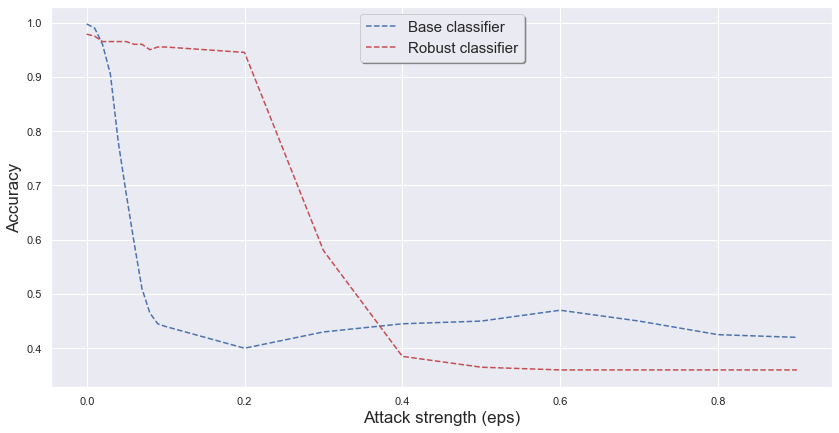

In [297]:
sns.set()
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(np.array(eps_range), np.array(accuracy_base), 'b--', label='Base classifier')
ax.plot(np.array(eps_range), np.array(accuracy_robust), 'r--', label='Robust classifier')
legend = ax.legend(loc='upper center', shadow=True, fontsize=15)
plt.xlabel('Attack strength (eps)', fontsize=17)
plt.ylabel('Accuracy', fontsize=17)
plt.show()